<a href="https://colab.research.google.com/github/ju-mava/analisis-sentimiento-trabajo-final-p3/blob/main/A3_Machetti_Vallverd%C3%BA_J%C3%BAlia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook, utilizaremos diferentes tipos de redes neuronales para realizar el análisis de sentimiento del dataset de Sentiment140.

De este modo, para análisis de sentimiento, construïmos un modelo de aprendizaje profundo con varios tipos de RNNs y diversos parámetros. Nos quedamos con el mejor modelo, es decir, aquel que obtenga los mejores resultados en el conjunto de evaluación. Probar LIME con algunas instancias por cada categoría.

# Análisis, preprocesamiento y preparación de los datos

In [11]:
import pandas as pd

In [12]:
#Cargamos el dataset en CSV como un dataframe

sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

In [13]:
# Asignar nombres a las columnas
sentiment140.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [14]:
# Muestreo estratificado para obtener 200.000 instancias manteniendo la proporción de clases
#Sobreescribimos el dataframe previo
sentiment140 = sentiment140.groupby('polarity', group_keys=False).apply(
    lambda x: x.sample(frac=200000/len(sentiment140), random_state=42)
).reset_index(drop=True)


<ipython-input-14-b17eeecbcd17>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment140 = sentiment140.groupby('polarity', group_keys=False).apply(


In [15]:
from sklearn.model_selection import train_test_split

# División en entrenamiento y temp (validación + test)
train_sentiment140, temp_sentiment140 = train_test_split(sentiment140, test_size=0.2, random_state=42, stratify=sentiment140['polarity'])

# División de temp en validación y test
val_sentiment140, test_sentiment140 = train_test_split(temp_sentiment140, test_size=0.5, random_state=42, stratify=temp_sentiment140['polarity'])

In [16]:
# Ahora tenemos tres conjuntos
print(f"Train: {len(train_sentiment140)} muestras")
print(f"Validación: {len(val_sentiment140)} muestras")
print(f"Test: {len(test_sentiment140)} muestras")

Train: 160000 muestras
Validación: 20000 muestras
Test: 20000 muestras


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [107]:
df_list = []

for df_split, split_name in [(train_sentiment140, "train"), (val_sentiment140, "dev"), (test_sentiment140, "test")]:
    df_split = df_split.copy()
    df_split["split"] = split_name
    df_list.append(df_split)

df = pd.concat(df_list)
df.head()


,polarity,id,date,query,user,text,split
81188,0,2183146110,Mon Jun 15 14:06:26 PDT 2009,NO_QUERY,lbartkowiak,@JBartkowiak I really miss my son,train
94598,0,2245416131,Fri Jun 19 16:06:04 PDT 2009,NO_QUERY,agoolsby,@stephenelliot Sorry so boring. But good work...,train
105172,4,2065364209,Sun Jun 07 08:26:35 PDT 2009,NO_QUERY,ezekiel78,@floydie14 don't forget to be in college tomor...,train
96404,0,2255165705,Sat Jun 20 10:51:24 PDT 2009,NO_QUERY,FrugaliciousMom,@lizzydear me too! My poor blk Lincoln is tell...,train
173301,4,2044644480,Fri Jun 05 09:38:13 PDT 2009,NO_QUERY,littleredwitch,@michellehv Hi Michelle! How are you? How is y...,train


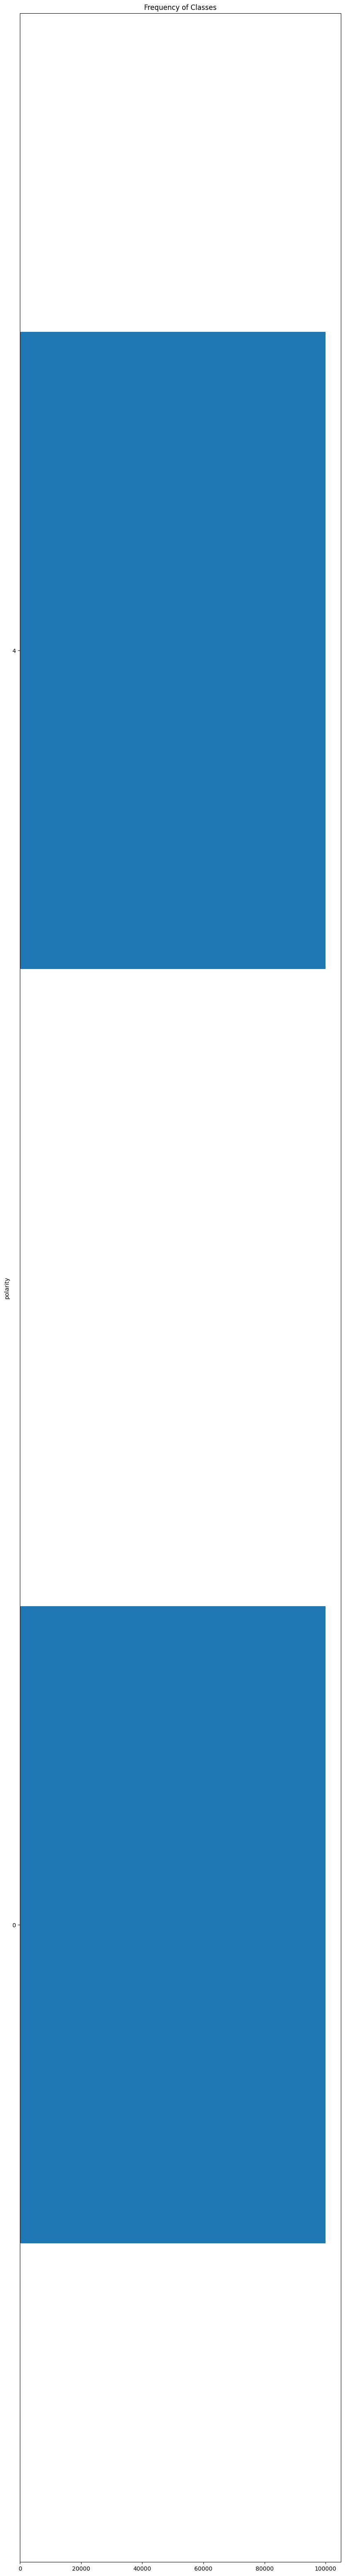

In [108]:
# Distribucion de instancias por clases (i.e. estrellas)

import matplotlib.pyplot as plt

df["polarity"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [109]:
# Nos quedamos con las columnas que nos interesan
df = df[['text', 'polarity', 'split']]
df

,text,polarity,split
81188,@JBartkowiak I really miss my son,0,train
94598,@stephenelliot Sorry so boring. But good work...,0,train
105172,@floydie14 don't forget to be in college tomor...,4,train
96404,@lizzydear me too! My poor blk Lincoln is tell...,0,train
173301,@michellehv Hi Michelle! How are you? How is y...,4,train
...,...,...,...
25683,#lions Things sure not going to script in Sout...,0,test
178822,Finally found the Bran Van 3000 song I've been...,4,test
97445,I'm kind of not happy at the moment. But Ferr...,0,test
2589,What a fantastic Sunday treat... http://short...,0,test


Vamos a dividir nuevamente el dataframe en tres, uno por split, aleatorizar los conjuntos de datos.

In [110]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,text,polarity,split
194685,@ddlovato thanks demi for the advice! â¥â¥â¥,4,train
146327,Sharing my breakfast with a blackbird..... I t...,4,train
91971,P.S Was gona do Wossy bk club as well as other...,0,train
57235,Girly Nite 2nite with face masks and takeaway....,0,train
9744,I miss school already,0,train
...,...,...,...
140105,@davecool83 I fell very honored ;) N thx 4 the...,4,train
7041,all this talk of up being The best movie of th...,0,train
19776,Probably the one and only time we will see Jor...,0,train
70728,Salad from krogers... I was hungry.,0,train


In [111]:
X_train = df_train['text']
X_valid = df_valid['text']
X_test = df_test['text']

X_train

,text
194685,@ddlovato thanks demi for the advice! â¥â¥â¥
146327,Sharing my breakfast with a blackbird..... I t...
91971,P.S Was gona do Wossy bk club as well as other...
57235,Girly Nite 2nite with face masks and takeaway....
9744,I miss school already
...,...
140105,@davecool83 I fell very honored ;) N thx 4 the...
7041,all this talk of up being The best movie of th...
19776,Probably the one and only time we will see Jor...
70728,Salad from krogers... I was hungry.


In [112]:
#0 refers to the negative and 1 to the positive
y_train = df_train['polarity'].map({0:0, 4:1}).values
y_valid = df_valid['polarity'].map({0:0, 4:1}).values
y_test = df_test['polarity'].map({0:0, 4:1}).values
y_train

array([1, 1, 0, ..., 0, 0, 0])

# Entrenamiento de redes neuronales

En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

**Tokenización y preprocesamiento**

Propósito: Convertir texto en representación numérica que la red neuronal pueda procesar.
Proceso:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

    Tokenizer():
        Crea un diccionario que asigna cada palabra única a un índice numérico.
        Ejemplo: {"el": 1, "servicio": 2, "excelente": 3, ...}.
    fit_on_texts(X_train):
        Analiza todos los textos de entrenamiento para construir el vocabulario.
        Solo se hace con los datos de entrenamiento para evitar "fugas" de información.


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq

[[15626, 116, 70, 218, 12, 3944, 1106, 49, 18, 551, 62, 37],
 [8297, 5, 977, 1898, 23, 389, 126, 13, 896, 4843],
 [39706,
  1,
  46,
  475,
  1111,
  1,
  62,
  16,
  4715,
  134,
  15,
  27,
  592,
  8,
  4,
  36,
  37,
  307,
  1,
  68,
  190,
  2219,
  523],
 [1, 81, 5, 4222, 1010, 14],
 [6453, 82, 10, 1862, 196, 59, 464, 122, 22, 83, 16, 4, 129, 30, 919],
 [18821, 58, 5516, 955, 513, 49],
 [69, 115, 218, 1, 64, 24, 197, 76],
 [15627,
  49,
  607,
  9387,
  8,
  234,
  45,
  46,
  130,
  33,
  69,
  142,
  2,
  67,
  457,
  8,
  13,
  3,
  78,
  849,
  3306],
 [47, 10, 373],
 [47, 32, 21, 5, 654, 6, 39707, 171, 230, 937, 390, 5, 852, 15, 91],
 [512,
  11,
  3,
  279,
  141,
  6752,
  237,
  32,
  3407,
  1171,
  107,
  8804,
  10,
  39708,
  5733,
  539,
  162,
  146,
  145,
  22,
  801],
 [39709, 11, 33, 30],
 [458, 1530, 1, 16, 4, 129, 30],
 [39710,
  137,
  12,
  539,
  13516,
  991,
  58,
  1676,
  1747,
  17,
  436,
  1326,
  511,
  2,
  22,
  119,
  1930,
  93,
  18,
  9,
  25

In [25]:
tokenizer.word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'is': 8,
 'it': 9,
 'for': 10,
 'in': 11,
 'of': 12,
 'on': 13,
 'me': 14,
 'so': 15,
 'have': 16,
 'that': 17,
 'but': 18,
 "i'm": 19,
 'just': 20,
 'with': 21,
 'be': 22,
 'at': 23,
 'not': 24,
 'was': 25,
 'now': 26,
 'this': 27,
 'good': 28,
 'up': 29,
 'day': 30,
 'get': 31,
 'out': 32,
 'all': 33,
 'like': 34,
 'are': 35,
 'no': 36,
 'go': 37,
 'quot': 38,
 'http': 39,
 'today': 40,
 'your': 41,
 "it's": 42,
 'work': 43,
 'do': 44,
 'too': 45,
 'love': 46,
 'going': 47,
 'got': 48,
 'lol': 49,
 'time': 50,
 'from': 51,
 'back': 52,
 'u': 53,
 'one': 54,
 'what': 55,
 'com': 56,
 'will': 57,
 'im': 58,
 'know': 59,
 'really': 60,
 'we': 61,
 "don't": 62,
 'about': 63,
 'am': 64,
 'amp': 65,
 'had': 66,
 'see': 67,
 'can': 68,
 "can't": 69,
 'its': 70,
 'some': 71,
 'if': 72,
 'night': 73,
 '2': 74,
 'still': 75,
 'well': 76,
 'want': 77,
 'new': 78,
 'how': 79,
 'home': 80,
 'think': 81,
 'thanks': 82,
 'there

**Creación de secuencias y padding**

Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 120. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 120 tokens.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 120. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [26]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 120

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_valid_pad = pad_sequences(X_valid_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

X_train_pad

array([[ 15626,    116,     70, ...,      0,      0,      0],
       [  8297,      5,    977, ...,      0,      0,      0],
       [ 39706,      1,     46, ...,      0,      0,      0],
       ...,
       [139111,   1139,  16238, ...,      0,      0,      0],
       [139115,    507,   1571, ...,      0,      0,      0],
       [     1,     64,    558, ...,      0,      0,      0]], dtype=int32)

## Red neuronal RNN básica con pooling: comparación embeddings 100/200/300

**Con embeddings de 100 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [28]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5373 - loss: 0.6860 - val_accuracy: 0.6714 - val_loss: 0.6315
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7048 - loss: 0.6043 - val_accuracy: 0.6423 - val_loss: 0.6468
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7416 - loss: 0.5658 - val_accuracy: 0.6457 - val_loss: 0.6574
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7651 - loss: 0.5305 - val_accuracy: 0.6812 - val_loss: 0.6293
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7864 - loss: 0.4976 - val_accuracy: 0.7109 - val_loss: 0.5985


In [29]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7062 - loss: 0.6029

Precisión en test: 0.7102


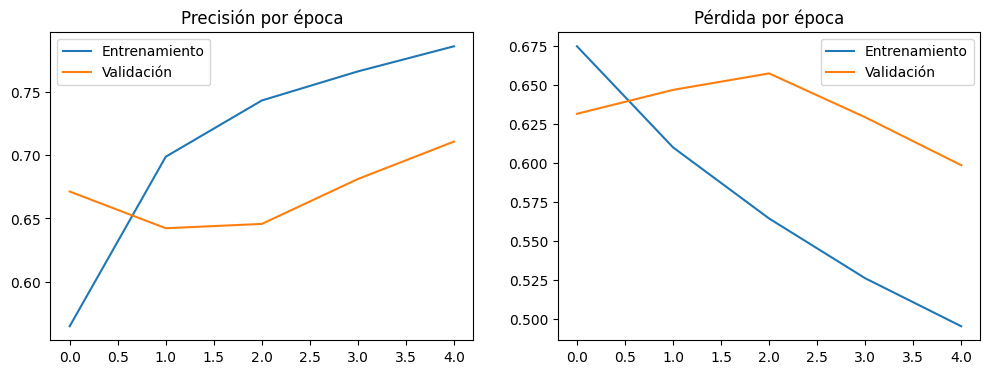

In [30]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, classification_report


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


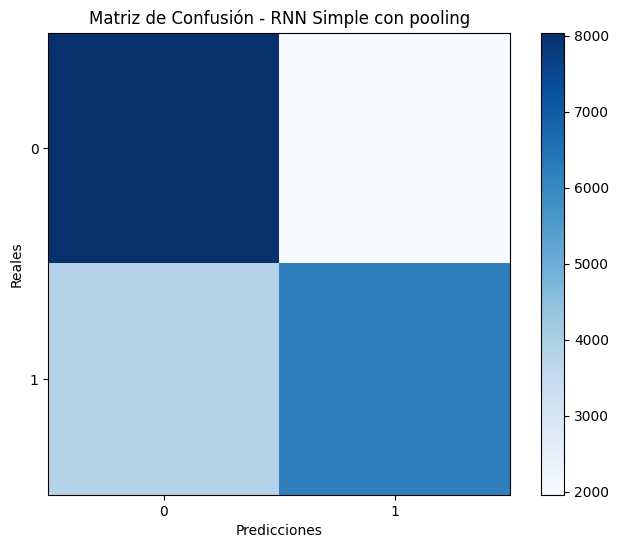

In [33]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [34]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.68      0.80      0.74     10000
  1:positive       0.76      0.62      0.68     10000

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000



**Con embeddings de 200 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 200                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [36]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5765 - loss: 0.6764 - val_accuracy: 0.7139 - val_loss: 0.5982
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7670 - loss: 0.5411 - val_accuracy: 0.6569 - val_loss: 0.6218
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8027 - loss: 0.4872 - val_accuracy: 0.7181 - val_loss: 0.5832
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8569 - loss: 0.4046 - val_accuracy: 0.7168 - val_loss: 0.5987
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8804 - loss: 0.3395 - val_accuracy: 0.7156 - val_loss: 0.5801


In [37]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7086 - loss: 0.5876

Precisión en test: 0.7147


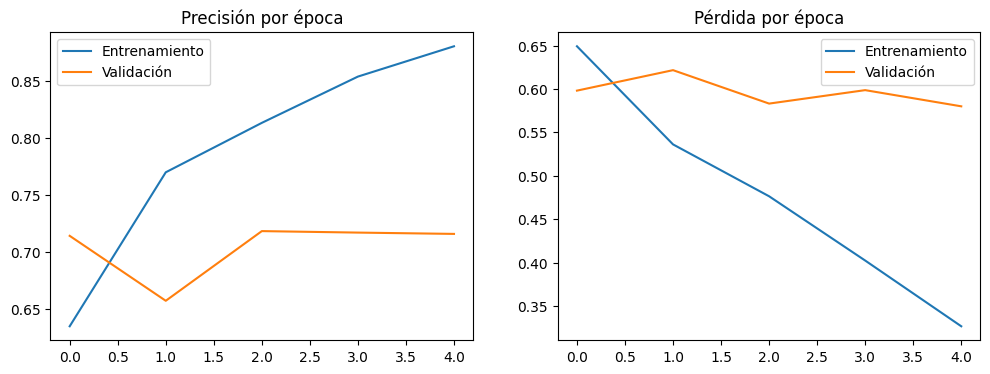

In [38]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


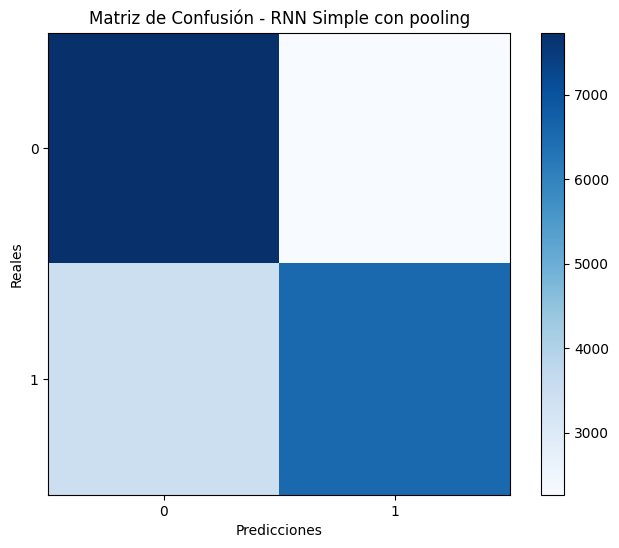

In [39]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [40]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.69      0.77      0.73     10000
  1:positive       0.74      0.66      0.70     10000

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000



**Con embeddings de 300 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [42]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.5747 - loss: 0.6801 - val_accuracy: 0.5111 - val_loss: 0.7800
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7053 - loss: 0.5988 - val_accuracy: 0.7333 - val_loss: 0.5646
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8165 - loss: 0.4734 - val_accuracy: 0.7190 - val_loss: 0.5844
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8554 - loss: 0.4194 - val_accuracy: 0.7174 - val_loss: 0.5951
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8846 - loss: 0.3504 - val_accuracy: 0.7225 - val_loss: 0.6211


In [43]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7171 - loss: 0.6335

Precisión en test: 0.7211


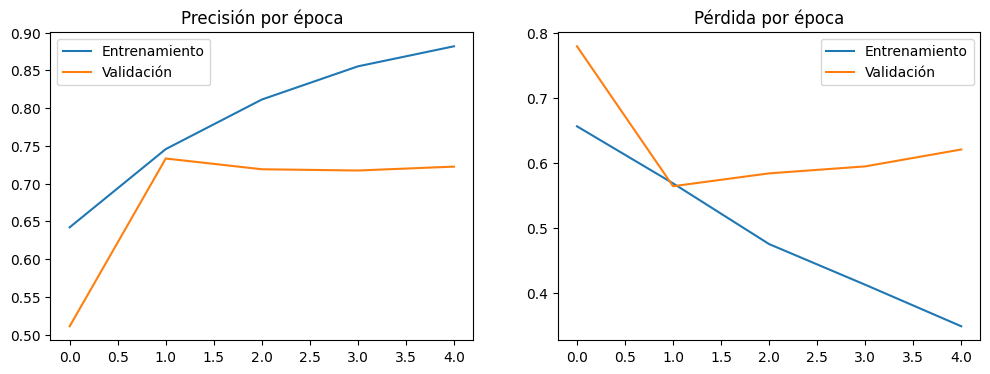

In [44]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


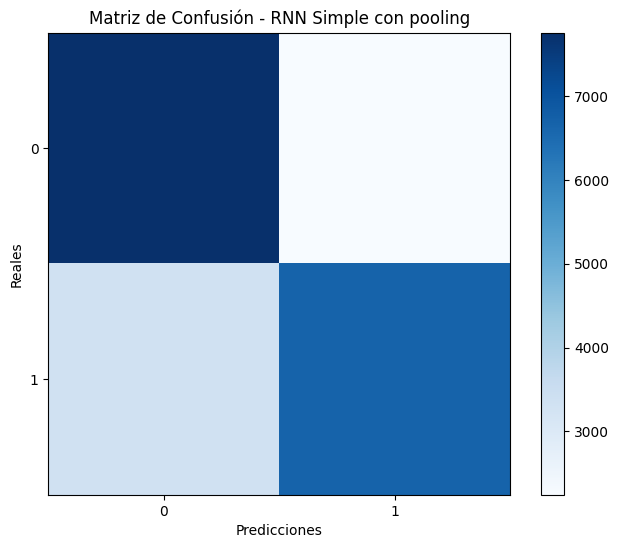

In [45]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [46]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.70      0.78      0.74     10000
  1:positive       0.75      0.67      0.71     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



**Nos quedamos con los embeddings de 300 dimensiones para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora (aunque la diferencia es mínima, de solo 0.01 en el weighted avg del f1-score).**

## Red neuronal RNN básica con pooling y embeddings de 300 dimensiones: comparación 64, 128 y 256 neuronas

**Con 128 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [62]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.5721 - loss: 0.6768 - val_accuracy: 0.5208 - val_loss: 0.6926
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6893 - loss: 0.6194 - val_accuracy: 0.7202 - val_loss: 0.5906
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.8015 - loss: 0.5106 - val_accuracy: 0.7222 - val_loss: 0.5684
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8331 - loss: 0.4391 - val_accuracy: 0.7176 - val_loss: 0.5953
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8676 - loss: 0.3828 - val_accuracy: 0.7211 - val_loss: 0.5923


In [63]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7201 - loss: 0.5984

Precisión en test: 0.7241


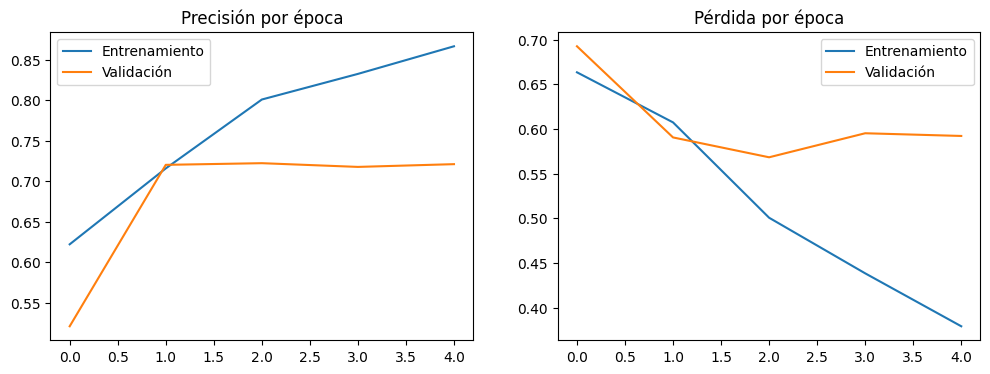

In [64]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


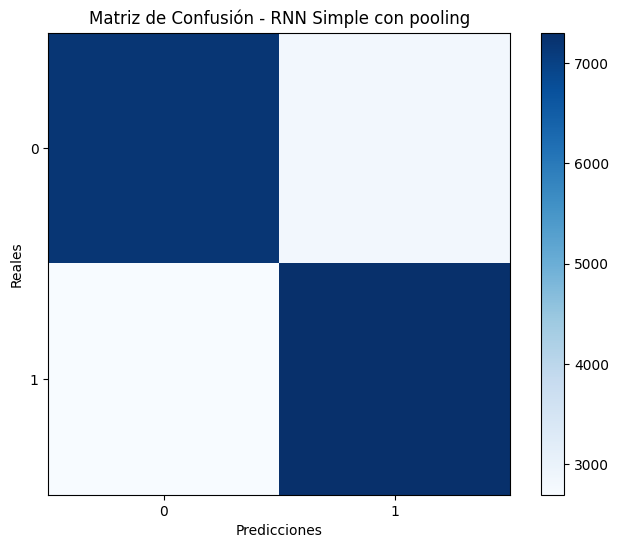

In [65]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [66]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.73      0.72      0.72     10000
  1:positive       0.72      0.73      0.73     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



**Con 64 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(64, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [68]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.6027 - loss: 0.6619 - val_accuracy: 0.6693 - val_loss: 0.6279
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7145 - loss: 0.5764 - val_accuracy: 0.6623 - val_loss: 0.6395
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7712 - loss: 0.5340 - val_accuracy: 0.6698 - val_loss: 0.6518
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7994 - loss: 0.4935 - val_accuracy: 0.5293 - val_loss: 0.6858


In [69]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5341 - loss: 0.6855

Precisión en test: 0.5306


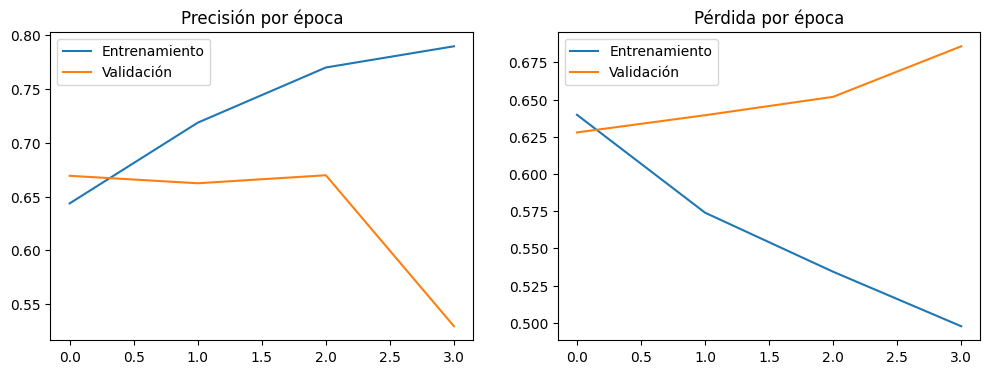

In [70]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


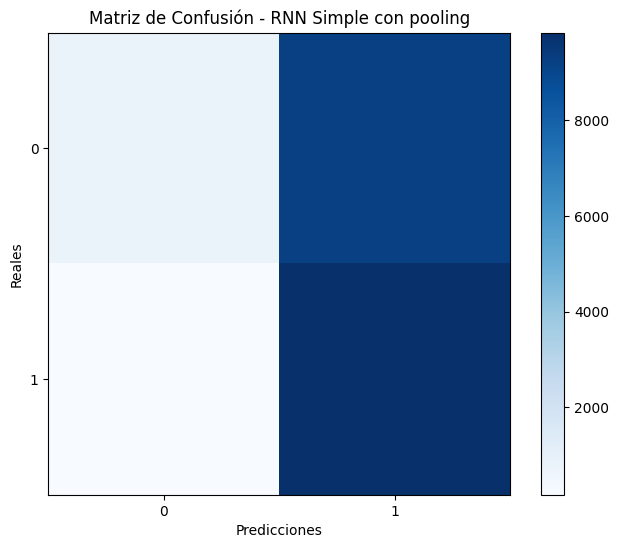

In [71]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [72]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.82      0.08      0.14     10000
  1:positive       0.52      0.98      0.68     10000

    accuracy                           0.53     20000
   macro avg       0.67      0.53      0.41     20000
weighted avg       0.67      0.53      0.41     20000



**Con 256 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                         # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(256, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [74]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.5555 - loss: 0.6841 - val_accuracy: 0.6442 - val_loss: 0.6375
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.6556 - loss: 0.6419 - val_accuracy: 0.6981 - val_loss: 0.6265
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7713 - loss: 0.5423 - val_accuracy: 0.7556 - val_loss: 0.5094
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8490 - loss: 0.3528 - val_accuracy: 0.7507 - val_loss: 0.5892
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8509 - loss: 0.4149 - val_accuracy: 0.6752 - val_loss: 0.6485


In [75]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6701 - loss: 0.6499

Precisión en test: 0.6755


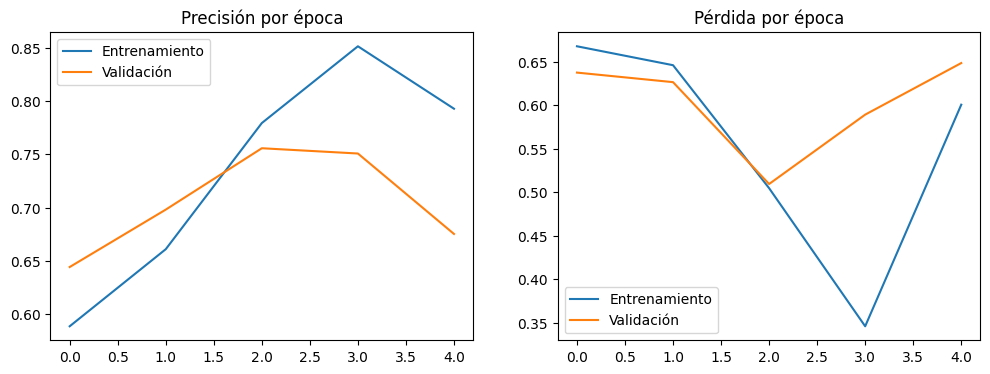

In [76]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


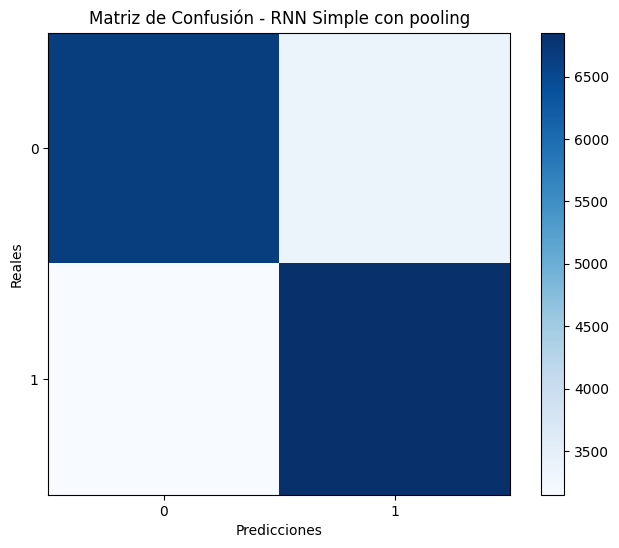

In [77]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [78]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.68      0.67      0.67     10000
  1:positive       0.67      0.69      0.68     10000

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



**Nos quedamos con las 128 neuronas y los embeddings de 100 dimensiones para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora.**

## Red neuronal RNN básica con pooling, 128 neuronas y embeddings de 300 dimensiones: comparación de 5, 10, 20 y 50 epochs

**Con 5 epochs (patience 3)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [80]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.5970 - loss: 0.6682 - val_accuracy: 0.7336 - val_loss: 0.5784
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7644 - loss: 0.5408 - val_accuracy: 0.6991 - val_loss: 0.6155
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8136 - loss: 0.5147 - val_accuracy: 0.7181 - val_loss: 0.5872
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8595 - loss: 0.4207 - val_accuracy: 0.7207 - val_loss: 0.5874


In [81]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7213 - loss: 0.5914

Precisión en test: 0.7229


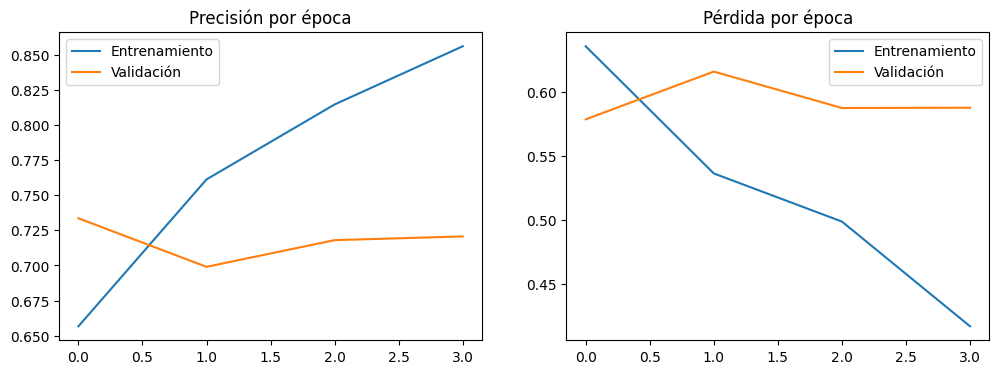

In [82]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


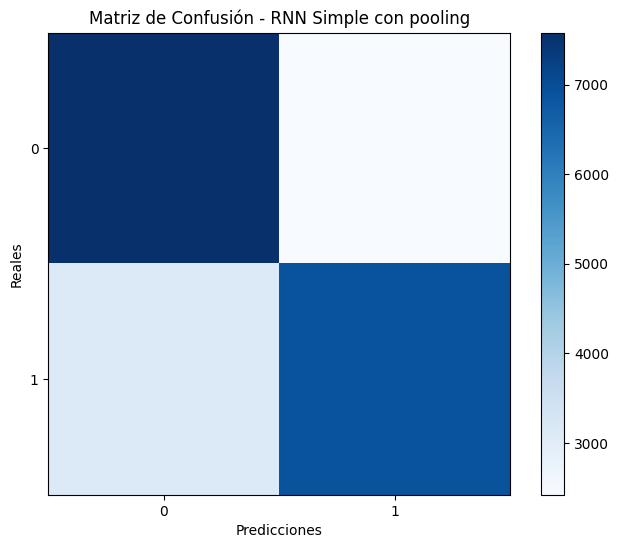

In [83]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [84]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.71      0.76      0.73     10000
  1:positive       0.74      0.69      0.71     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



**Con 10 epochs (patience 3)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [86]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.5869 - loss: 0.6722 - val_accuracy: 0.6606 - val_loss: 0.6353
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7167 - loss: 0.5881 - val_accuracy: 0.5329 - val_loss: 0.6797
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6507 - loss: 0.6523 - val_accuracy: 0.7329 - val_loss: 0.6028
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8066 - loss: 0.5107 - val_accuracy: 0.7291 - val_loss: 0.5740
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8518 - loss: 0.4182 - val_accuracy: 0.7421 - val_loss: 0.6411
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8728 - loss: 0.3291 - val_accuracy: 0.7451 - val_loss: 0.5533
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8906 - loss: 0.3055 - val_accuracy: 0.7426 - val_loss: 0.5798
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9069 - loss: 0.2629 - 

In [87]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7377 - loss: 0.6578

Precisión en test: 0.7436


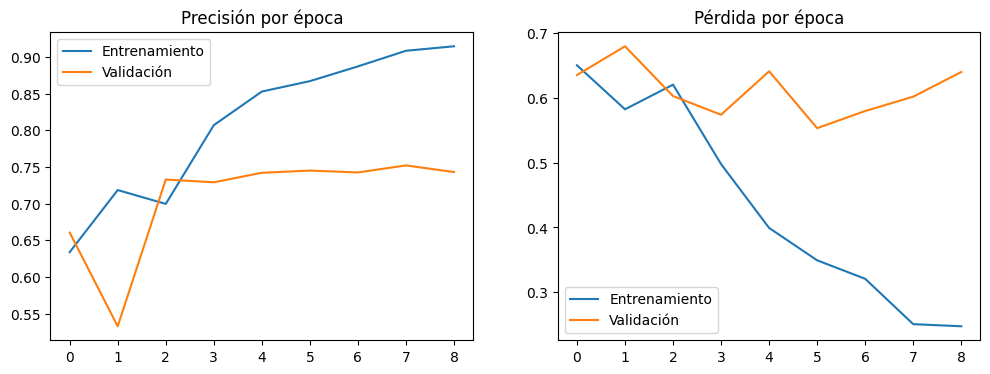

In [88]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


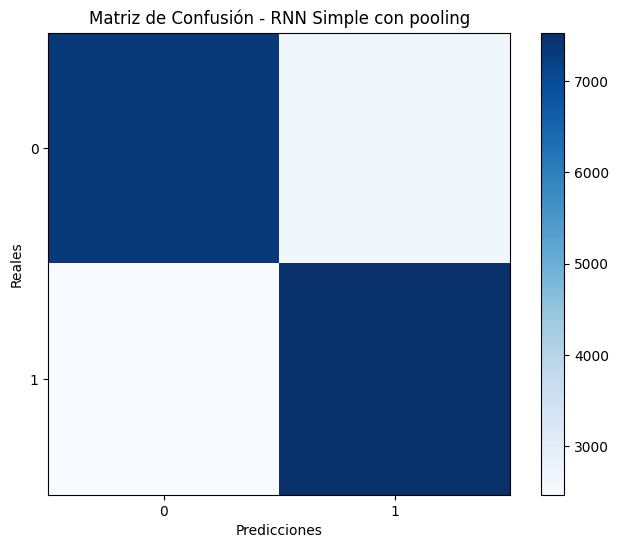

In [89]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [90]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.75      0.73      0.74     10000
  1:positive       0.74      0.75      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



**Con 20 epochs (patience 5)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [92]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=20,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5680 - loss: 0.6872 - val_accuracy: 0.6854 - val_loss: 0.6463
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7301 - loss: 0.6023 - val_accuracy: 0.7241 - val_loss: 0.5764
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8086 - loss: 0.4912 - val_accuracy: 0.7203 - val_loss: 0.5815
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8553 - loss: 0.4120 - val_accuracy: 0.7107 - val_loss: 0.6174
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8801 - loss: 0.3585 - val_accuracy: 0.7176 - val_loss: 0.6326
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8963 - loss: 0.3103 - val_accuracy: 0.7181 - val_loss: 0.6805
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9081 - loss: 0.2769 - val_accuracy: 0.7221 - val_loss: 0.6153


In [93]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7218 - loss: 0.6228

Precisión en test: 0.7271


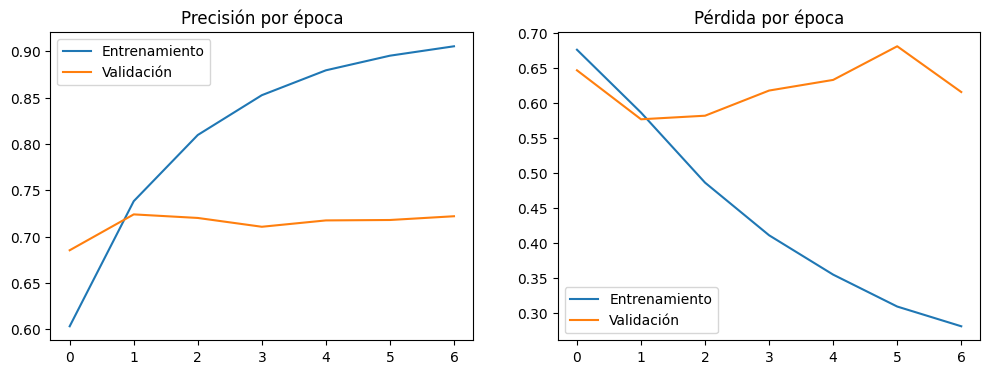

In [94]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


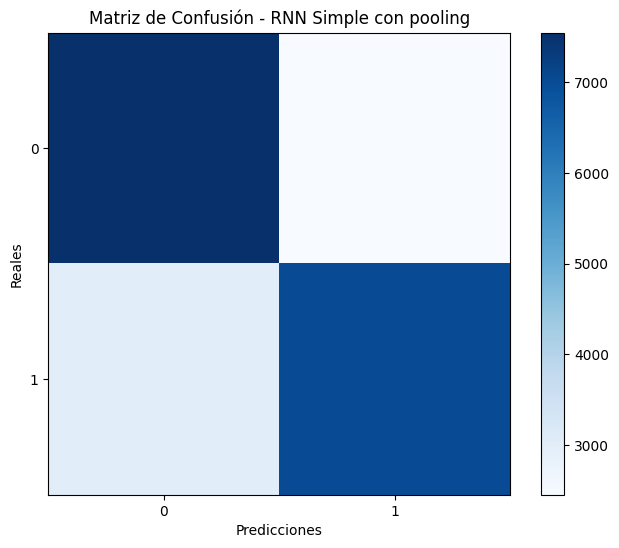

In [95]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [96]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.72      0.75      0.73     10000
  1:positive       0.74      0.70      0.72     10000

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



**Con 50 epochs (patience 10)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [98]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=50,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.6049 - loss: 0.6728 - val_accuracy: 0.5666 - val_loss: 0.6711
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7418 - loss: 0.5640 - val_accuracy: 0.7335 - val_loss: 0.5648
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8096 - loss: 0.4814 - val_accuracy: 0.6569 - val_loss: 0.6737
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8425 - loss: 0.4126 - val_accuracy: 0.7401 - val_loss: 0.5450
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8690 - loss: 0.3760 - val_accuracy: 0.7231 - val_loss: 0.5839
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8893 - loss: 0.3245 - val_accuracy: 0.7333 - val_loss: 0.5989
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8834 - loss: 0.3314 - val_accuracy: 0.7484 - val_loss: 0.5919
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9035 - loss: 0.2601 - 

In [99]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7436 - loss: 0.7284

Precisión en test: 0.7465


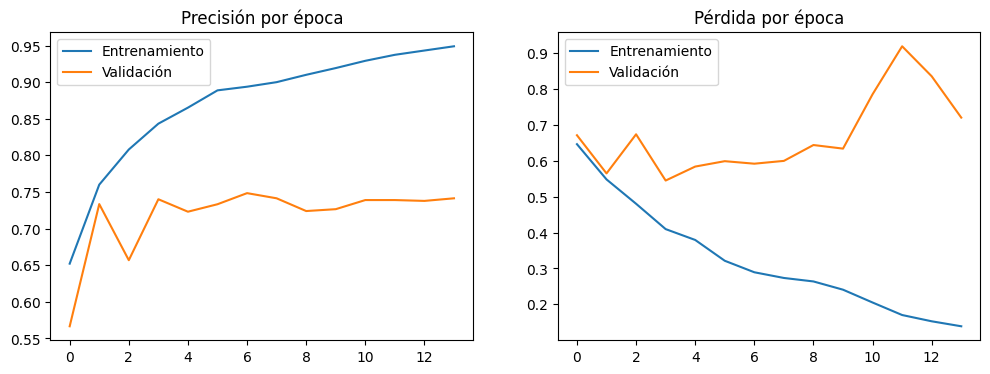

In [100]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


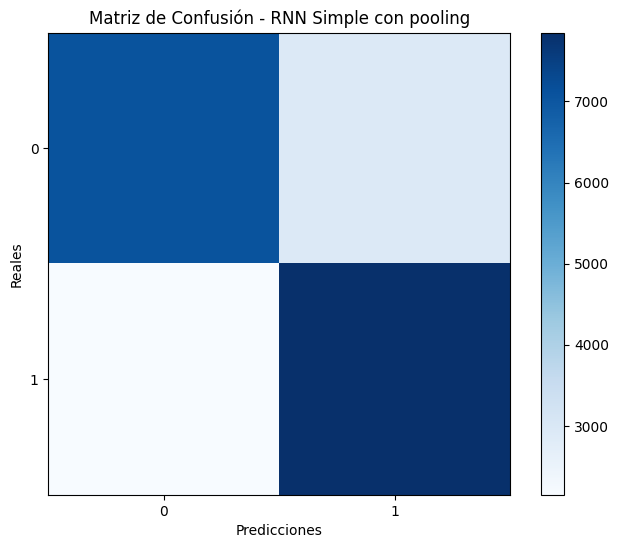

In [101]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [102]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.77      0.71      0.74     10000
  1:positive       0.73      0.78      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



**Nos quedamos con las 128 neuronas, los embeddings de 300 dimensiones y los 50 epochs con patience 10 para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora. De hecho, conseguimos una f1-score de 0.75 tanto para accuracy como para macro avg y weighted avg. Este es el mejor resultado que hemos obtenido de todas las combinaciones que hemos probado.**

Para probar distintas combinaciones de parámetros, he seguido una metodología sistemática y coherente comprobando primero las variaciones de uno solo parámetro para así quedarme con la opción que mejores resultados ofrece. Definido así el primer parámetro, podemos pasar al siguiente y probar también todas sus opciones manteniendo estable el primer parámetro seleccionado para todas ellas, y así sucesivamente, hasta que todos hayan quedado definidos.  

Durante el proceso de entrenamiento del modelo con una red neuronal básica con pooling, he evaluado distintas configuraciones para encontrar la combinación óptima teniendo en cuenta los siguientes factores: dimensión de los embeddings, número de neuronas en la capa oculta y número de épocas (con la patience correspondiente). Después del experimento nos quedamos con las 128 neuronas, los embeddings de 300 dimensiones y los 50 epochs con patience 10, ya que son los que mejores resultados nos han dado hasta ahora. De hecho, conseguimos una f1-score de 0.75 tanto para accuracy como para macro avg y weighted avg. Este es el mejor resultado que hemos obtenido de todas las combinaciones que hemos probado.

**Dimensión de los embeddings**: He probado con vectores de embeddings de 100, 200 y 300 dimensiones. El modelo con embeddings de 300 dimensiones es el que ha obtenido el mejor rendimiento general. Esto puede explicarse porque los embeddings de mayor dimensión permiten una representación semántica más rica de las palabras, capturando matices más complejos del lenguaje. Aunque los embeddings de menor dimensión son más eficientes computacionalmente, en este caso la mejora en la precisión justifica el coste computacional mayor en el que incurrimos.

**Número de neuronas en la capa oculta**: Una vez fijado el tamaño óptimo de los embeddings (300 dimensiones), he probado de adaptar la capacidad del modelo variando el número de neuronas en la capa densa (64, 128 y 256). El mejor rendimiento lo he conseguido con 128 neuronas, que, al ser la opción intermedia, equilibra la capacidad de aprendizaje y el riesgo de sobreajuste. Con 64 neuronas, el modelo probablemente no disponía de suficiente capacidad para aprender patrones complejos; mientras que con 256 neuronas, no hubo una mejora significativa debido al sobreajuste.

**Número de épocas de entrenamiento**: Por último, he experimentado con distintas duraciones del entrenamiento (5, 10, 20 y 50 épocas). Cabe comentar que la variación en la cantidad de epochs no ha modificado prácticamente nada los resultados. De todas formas, debemos tener en cuenta que siempre hemos adaptado la patience proporcionalmente a la cantidad de epochs seleccionada, pudiendo ser este un aspecto que ha incidido en los resultados. En conclusión, esto justificaría que no hayamos observado diferencias significativas en el rendimiento final. De hecho, esto permite que el modelo deje de entrenar una vez alcanzada la convergencia, independientemente del máximo de épocas establecido. Este comportamiento indica que el modelo converge rápidamente y que extender las épocas más allá de un cierto punto no aporta más beneficios.

#MODELO DEFINITIVO PARA RNNs

No es necesario volñver a cargarlo, ya que es el último que hemos ejecutado. Por ello, cuando recurramos a variables como y_pred, seran las aportadas por las predicciones de este modelo, que ha sido el seleccionado por mostrar un rendimiento superior al resto.

In [113]:
df_test

,text,polarity,split
8820,"It's saturday, cold and rainy, where has summe...",0,test
83415,Today is a *very* tired Monday. Weekend was n...,0,test
113734,@daverosstomlin watch the profanity finchy.,4,test
88517,"@tommcfly no, I'm not",0,test
108885,@QueenBea33 why were u mad?? and ooh i wanna s...,4,test
...,...,...,...
2763,The 1st class flight attendant is so hawt yall...,0,test
90202,is incredibly sad right now,0,test
140825,Is Twitter working again??? Is it safe to come...,4,test
95102,@PioneerHall argg I feel so bad that I was tol...,0,test


In [114]:
df_test["polarity"] = df_test["polarity"].map({0: 0, 4: 1})

In [115]:
df_test

,text,polarity,split
8820,"It's saturday, cold and rainy, where has summe...",0,test
83415,Today is a *very* tired Monday. Weekend was n...,0,test
113734,@daverosstomlin watch the profanity finchy.,1,test
88517,"@tommcfly no, I'm not",0,test
108885,@QueenBea33 why were u mad?? and ooh i wanna s...,1,test
...,...,...,...
2763,The 1st class flight attendant is so hawt yall...,0,test
90202,is incredibly sad right now,0,test
140825,Is Twitter working again??? Is it safe to come...,1,test
95102,@PioneerHall argg I feel so bad that I was tol...,0,test


In [117]:
df_test["predicted_label"] = y_pred

In [118]:
df_test

,text,polarity,split,predicted_label
8820,"It's saturday, cold and rainy, where has summe...",0,test,1
83415,Today is a *very* tired Monday. Weekend was n...,0,test,1
113734,@daverosstomlin watch the profanity finchy.,1,test,1
88517,"@tommcfly no, I'm not",0,test,0
108885,@QueenBea33 why were u mad?? and ooh i wanna s...,1,test,1
...,...,...,...,...
2763,The 1st class flight attendant is so hawt yall...,0,test,1
90202,is incredibly sad right now,0,test,1
140825,Is Twitter working again??? Is it safe to come...,1,test,1
95102,@PioneerHall argg I feel so bad that I was tol...,0,test,1


In [119]:
df_test.loc[8820, "text"]

"It's saturday, cold and rainy, where has summer gone? "

In [120]:
df_test.loc[83415, "text"]

'Today is a *very* tired Monday.  Weekend was not good for catching up on sleep as I hoped it would be.  Makes me write in passive voice. '

In [121]:
df_test.loc[2763, "text"]

'The 1st class flight attendant is so hawt yall....but o so GAY '

In [122]:
df_test.loc[90202, "text"]

'is incredibly sad right now '

In [123]:
df_test.loc[95102, "text"]

"@PioneerHall argg I feel so bad that I was told the wrong time, then told everyone else the wrong time!  my mind hasn't been with me"

#LIME

In [124]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=be92f20b883bc1a6d30a78eb967a084ddf6dd9c4deac9f467da22559facb0f15
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [125]:
from lime.lime_text import LimeTextExplainer
# Función de predicción para LIME
def predict_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return model_pool.predict(padded)

# Crear explicador
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

In [128]:
# Explicar una predicción
idx = 88517  # Índice del ejemplo a explicar
exp = explainer.explain_instance(X_test[idx], predict_lime, num_features=10, top_labels=2)

# Mostrar explicación
exp.show_in_notebook(text=X_test[idx])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
